In [71]:
import os
import gc
import shutil
if os.getenv("COLAB_RELEASE_TAG"):
    # Colab
    print("RUNING ON COLAB")
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/GaggleSignLang/asl-signs"
    WORKING_DIR = "/content/asl-work"
    ARCHIVE_DIR = "/content/drive/MyDrive/GaggleSignLang"
    MODEL_DIR = "/content/drive/MyDrive/GaggleSignLang/models"
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    # KAGGLE
    print("RUNNING ON KAGGLE")
    BASE_DIR = "/kaggle/input/asl-signs"
    WORKING_DIR = "/kaggle/working"
    ARCHIVE_DIR = "/kaggle/working"
    MODEL_DIR  = "/kaggle/working"
else: 
    # Jupiter  MacOS
    print("RUNING JUPITER LOCAL")
    BASE_DIR = "/Users/johnhanratty/ASLtest/asl-signs"  #"/Users/johnhanratty/ASLtest/asl-signs"
    WORKING_DIR = "/Users/johnhanratty/ASLtest"
    ARCHIVE_DIR = "/Users/johnhanratty/ASLtest"
    MODEL_DIR = "/Users/johnhanratty/ASLtest/models"

import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
from random import seed, sample

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 96 # 16
PCA_COMPONENTS = 120
PTS_IN_FRAME = 345
DIMC = [0,1,2]
DIMS = len(DIMC)
WORKERS = 0   # dataoader work var  0 for MAC, 4 for online


print('done')

RUNING JUPITER LOCAL
done


In [72]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [73]:
# CNN TORCH FEATUREGEN MODEL 
ROWS_PER_FRAME = 543  # combined face, lefth, pose, righth
PR_PTS = [40, 44, 48, 52, 56, 60, 43, 46, 50, 54, 58]
SC_PTS = [40, 98, 102, 106, 110, 114, 97, 102, 106, 110, 114]
PO_PTS = [60, 73, 80, 81, 76, 77, 68, 69, 70, 71, 75, 74]
LI_PTS = [5, 0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
PR_LEN = len(PR_PTS) * DIMS * 5  # 5 = number of aggregations e.g. max,min
SC_LEN = len(SC_PTS) * DIMS * 5
PO_LEN = len(PO_PTS) * DIMS * 5
LI_LEN = len(LI_PTS) * DIMS * 5
CNN_FEAT_LEN = PR_LEN + SC_LEN + PO_LEN + LI_LEN 

print("Feature Len", CNN_FEAT_LEN, PR_LEN, SC_LEN, PO_LEN, LI_LEN)

# FILTER FEATURES IN EACH FRAME  - FACE, POSE & HANDs
class FeatureGen(nn.Module):
    def __init__(self):
        super(FeatureGen, self).__init__()
        print(MODEL_DIR)
        with open(f"{MODEL_DIR}/PCAmod_96_120.pkl", 'rb') as handle:
            self.pca_X = pickle.load(handle)

 
        pass
    
    def forward(self, x):
        x = torch.tensor(x)
        
        # FILTER TO SPECIFIED FRAMES (FRAMES_OUT)
        seed(24)
        n_frames = x.size()[0]
        # Trim to # of frames to FRAMES_OUT
        if n_frames > FRAMES_OUT:
            idx = sorted((sample(range(0, n_frames), FRAMES_OUT)))
            x=x[idx]
        n_frames = x.size()[0]
        # FLATTENING ROWS BY TYPE and CONCATENATING TO ONE ROW PER FRAME 3D (XYZ)
        # INPUT NUMPY, TORCH OUTPUT

        # The Video contains n_frames each containing exactly ROWS_PER_FRAME (543)frames.
        # The frames in each are in order of feature type.
        # The rows conain x, y, z for a feature
        #   Video Format = [n_frames][543 frames][3 xyz coordinates]
        
        # Create views by data type (e.g. one point on hand) 
        # by selecting rows for each frame
        # face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lips_idx = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
        lips_x = x[:, lips_idx,:].contiguous().view(-1, len(lips_idx)*3)
        lefth_x = x[:,468:489,:].contiguous().view(-1, 21*3)
        pose_x = x[:,489:522,:].contiguous().view(-1, 33*3)
        righth_x = x[:,522:,:].contiguous().view(-1, 21*3)

        # Check for primary hand and if left hand swap and rotate hands
        if torch.isnan(lefth_x).sum() < torch.isnan(righth_x).sum():
            prime_x = lefth_x
            second_x = righth_x
        else:
            prime_x = righth_x.reshape(righth_x.size()[0], -1, DIMS)
            prime_x[:,:,0] = torch.from_numpy(np.subtract(np.nanmax(prime_x[:,:,0].numpy(), axis=1).reshape(-1,1),
                                    prime_x[:, :, 0].numpy()))
            prime_x = prime_x.reshape(prime_x.size()[0],-1)
            
            second_x = lefth_x.reshape(lefth_x.size()[0], -1, DIMS)
            second_x[:,:,0] = torch.from_numpy(np.subtract(np.nanmax(second_x[:,:,0].numpy(), axis=1).reshape(-1,1),
                                          second_x[:, :, 0].numpy()))
            second_x = second_x.reshape(second_x.size()[0],-1)
            
        
        # create video withfixed number of frames (FRAMES_OUT)
        # initialize with NoN so later operations can ignore them (e.g. nanmean()) 
        xfeat = torch.full([FRAMES_OUT, PTS_IN_FRAME], np.nan)
        
        # center frames
        offset = (FRAMES_OUT - n_frames) // 2  # center frames in output data in each frame in video
        
        # flatten types into one row per frame
        xfeat[offset:n_frames+offset,:] = torch.cat([lips_x, prime_x, pose_x, second_x], axis=1)  # concatenate types               
        ################### 
        
        #xfeat = np.nan_to_num(xfeat, copy=False)       
        #pca_out = self.pca_X.transform(xfeat.reshape(xfeat.shape[0],-1))     
        #if len(pca_out.shape) < 3:
          #pca_out = np.expand_dims(pca_out, axis=0)
        #pca_out = pca_out.reshape(pca_out.shape[0], pca_out.shape[1], -1)
        #pca_out = np.swapaxes(pca_out,2,1)
        
        xfeat = torch.where(torch.isnan(xfeat), torch.tensor(0.0, dtype=torch.float32), xfeat)
        pca_out = torch.from_numpy(self.pca_X.transform(xfeat.reshape(xfeat.shape[0],-1).numpy()))
        if len(pca_out.size()) < 3:
            pca_out = torch.unsqueeze(pca_out, 0)
        pca_out = pca_out.reshape(pca_out.size()[0], pca_out.size()[1], -1)
        pca_out = torch.swapaxes(pca_out,2,1)

        return pca_out



Feature Len 675 165 165 180 165


In [74]:

## PROCESS EACH ROW (ONE PARQUET PER ROW)
def convert_row(row):
    x = load_relevant_data_subset(os.path.join(BASE_DIR, row[1].path))
    x = feature_converter(torch.tensor(x))
    return x, row[1].label

## LOOP THROUGH PARQUET FILES LISTED IN TRAIN FILE
##  SAVE RESULTS 
def convert_and_save_data():
    label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
    df = pd.read_csv(TRAIN_FILE)
    df['label'] = df['sign'].map(label_map)
    
    print("Convert&Save", df.shape)
    #### FOR TESTING #################
    #df = df[0:20]
    ##################################

    PCA_COMPONENTS = 120
    npdata = np.zeros((df.shape[0], PCA_COMPONENTS, FRAMES_OUT))
    nplabels = np.zeros(df.shape[0])
    
    results = map(convert_row, df.iterrows())
    for i, (x,y) in tqdm(enumerate(results), total=df.shape[0]):
            npdata[i,:] = x
            nplabels[i] = y
    return npdata, nplabels
 

feature_converter = FeatureGen()
datax, datay = convert_and_save_data()



/Users/johnhanratty/ASLtest/models
Convert&Save (94477, 5)


100%|████████████████████████████████████| 94477/94477 [09:53<00:00, 159.07it/s]


In [75]:
# Save dataset
np.save(f"{WORKING_DIR}/tsai_data{FRAMES_OUT}.npy", datax)
np.save(f"{WORKING_DIR}/tsai_labels.npy", datay)
 

In [ ]:
# Load dataset
datax = np.load(f"{ARCHIVE_DIR}/tsai_data{FRAMES_OUT}.npy")
datay = np.load(f"{ARCHIVE_DIR}/tsai_labels.npy") 

# datax = np.load(f"/kaggle/input/tsai-data/tsai_data32.npy")
# datay = np.load(f"/kaggle/input/tsai-data/tsai_labels.npy") 


# PCA Encoding

In [ ]:
# from sklearn.decomposition import PCA
# COMPONENTS = 60
# print(datax.shape)

# datax = np.nan_to_num(datax, copy=False)
# shp = datax.shape
# pca_X = PCA(n_components=COMPONENTS, random_state=999) 
# pca_X.fit(datax.reshape(shp[0]*shp[1], -1))
# print(np.cumsum(pca_X.explained_variance_ratio_ *100))

# with open(f"{MODEL_DIR}/modelPCA_60.pkl", 'wb') as handle:
#     pickle.dump(pca_X, handle)


In [ ]:
print(np.cumsum(pca_X.explained_variance_ratio_ *100))

NameError: ignored

# TSAI INCEPTION
## Data
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01a_MultiClass_MultiLabel_TSClassification.ipynb 
## TS Model
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 


In [24]:
!pip install tsai --quiet
from tsai.all import *
from fastai.callback.tracker import EarlyStoppingCallback

my_setup()

os              : macOS-10.16-x86_64-i386-64bit
python          : 3.8.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.0
cpu cores       : 8
threads per cpu : 2
RAM             : 16.0 GB
GPU memory      : N/A


In [25]:
# INSTEAD OF PREVIOUS CELL
# USE np data already split
# https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 

EPOCHS = 40
BATCH_SIZE = 64

def tsai_dls(datax, datay):
  # datax = datax.reshape(datax.shape[0], datax.shape[1], -1)
  # datax = np.swapaxes(datax,2,1)
  # datax = np.nan_to_num(datax, copy=False)

  trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

  X, Y, splits = combine_split_data([trainx, testx], [trainy, testy])
  tfms  = [None, TSClassification()] # TSClassification == Categorize
  batch_tfms = TSStandardize()

  #dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)
  #dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())

  dls = get_ts_dls(X, Y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=BATCH_SIZE)
  print(X.shape, Y.shape)
  return dls, X, Y, splits

dls, X, Y, splits = tsai_dls(datax, datay)

pred_list = pd.DataFrame(Y[splits[1]], columns=["truth"])


(94477, 60, 64) (94477,)


SuggestedLRs(valley=0.0003311311302240938)

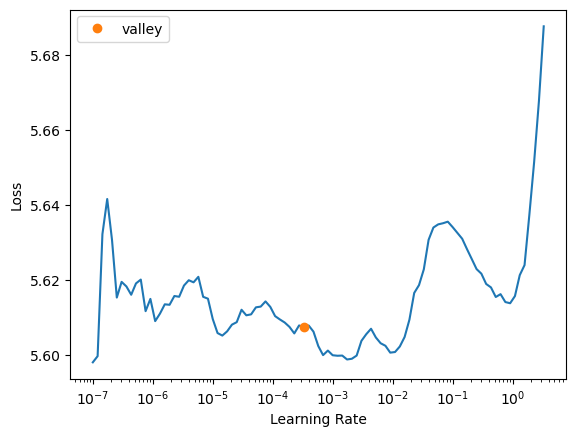

In [26]:
# LEARNING RATE
model = build_ts_model(InceptionTimePlus, dls=dls, depth=9, nf=64, fc_dropout=0, conv_dropout=0)  
learni = Learner(dls, model, metrics=accuracy)
learni = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch
learni.lr_find()



epoch,train_loss,valid_loss,accuracy,time
0,5.201741,5.186902,0.000000,09:33
1,4.477640,4.460530,0.000000,07:32
2,3.624776,3.591114,0.000000,07:27
3,2.967272,3.070645,0.000000,08:01
4,2.503006,2.532471,0.000000,08:37


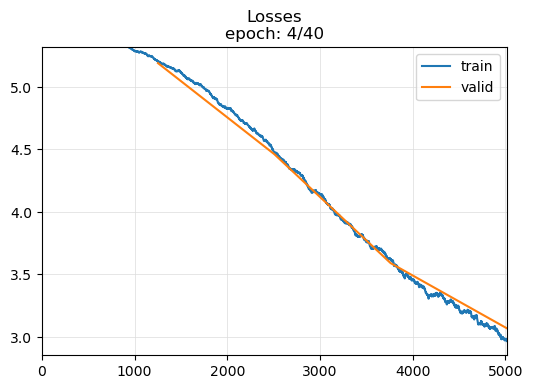

No improvement since epoch 0: early stopping


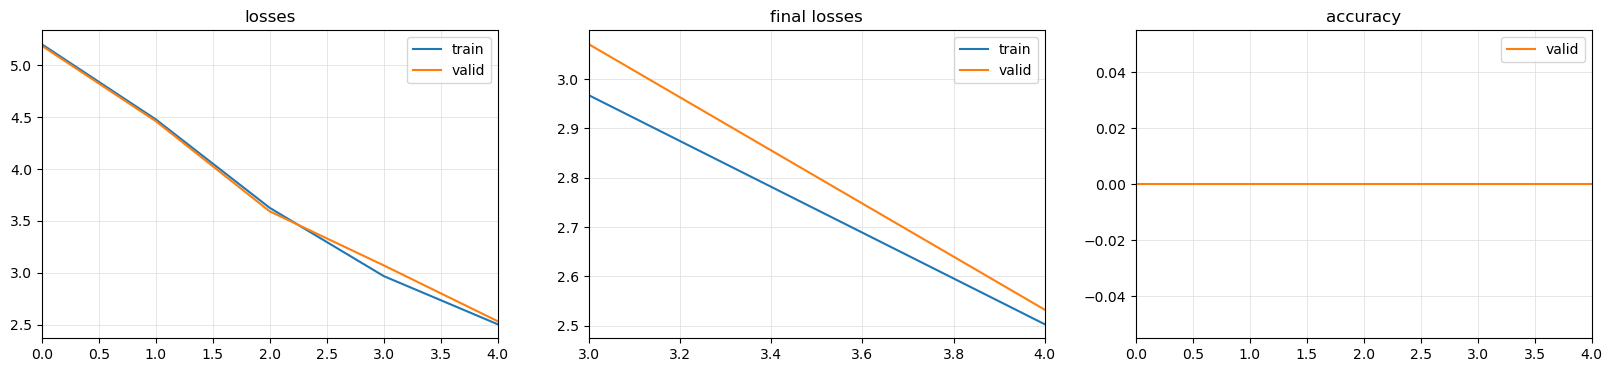

In [29]:
# early stop https://docs.fast.ai/callback.tracker.html 
EPOCHS=40
learni = ts_learner(dls, metrics=accuracy, cbs=[ShowGraph(), EarlyStoppingCallback(monitor='accuracy', patience=4)])
#learni = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learni.fit_one_cycle(EPOCHS, lr_max=10e-4)

#SAVE PROB/PRED
probasi, _, predsi = learni.get_X_preds(X[splits[1]])

with open(f"{MODEL_DIR}/prob_incept.pkl", 'wb') as f3:
       pickle.dump(probasi,f3)

pred_list['incept'] = predsi
with open(f"{MODEL_DIR}/pred_tsai.pkl", 'wb') as f4:
       pickle.dump(pred_list,f4)

## SAVE MODEL
PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.pkl"
torch.save(learni.model, PATH)

PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.sd"
torch.save(learni.model.state_dict(), PATH)



32FRAME INPUT


In [ ]:
64 FRAMES TENSOR FEAT GEN
32	0.308407	1.187585	0.737017	02:51
33	0.286050	1.194081	0.733841	02:51
34	0.285561	1.205711	0.734406	02:51

32 FRAME TENSOR FEAT GETN
32	0.292746	1.313657	0.723680	00:45
33	0.239469	1.313424	0.722622	00:45
34	0.228079	1.313393	0.724104	00:45


64-FRAMES/PCI60
33	0.295558	1.188239	0.737793	02:46
34	0.298747	1.187957	0.736593	02:46
35	0.284587	1.195939	0.734970	02:46

32-FRAMES/PCI60 early
22	0.630780	1.188958	0.718106	00:43
23	0.605225	1.214742	0.713731	00:43
24	0.558536	1.216527	0.715072	00:43

30	0.321596	1.295961	0.716765	00:43
31	0.298942	1.304625	0.717683	00:43


# Inception Inference

In [ ]:
# SAVE PYTORCH MODELS
# Try Model with both Feature Gen and Model

class AModel(nn.Module):
    def __init__(self):
        super(AModel, self).__init__()
        
        self.InputFormat = FeatureGen()
        PATH = f"{MODEL_DIR}/model_incept{FRAMES_OUT}.pkl"
        model = torch.load(PATH) #learni.model  #learni.get_X_preds 
        self.InferModel = model.cpu()
        #self.InferModel.eval()
    
    def forward(self, x):
        x = self.InputFormat(x)
        # if len(x.shape) < 3:
        #   x = np.expand_dims(x, axis=0)
        # x = x.reshape(x.shape[0], x.shape[1], -1)
        # x = np.swapaxes(x,2,1)
        #x = np.nan_to_num(x, copy=False)


        print(x.shape)
        pred = self.InferModel(torch.tensor(x).cpu().float())
        return pred



label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
df = pd.read_csv(TRAIN_FILE)
df['label'] = df['sign'].map(label_map)
df.shape

(94477, 5)

In [ ]:
d = df[2000:2001]   #2000, 2001
print(d['path'])
mod = AModel()
x = load_relevant_data_subset(os.path.join(BASE_DIR, d['path'].item()))
print("Main", x.shape)
pred = mod(x)

print("pred", type(pred))

print("truth:", d.label, d.sign, "prediction=", np.argmax(pred[0].detach().numpy()))


2000    train_landmark_files/28656/1082593511.parquet
Name: path, dtype: object
/content/drive/MyDrive/GaggleSignLang/models
Main (26, 543, 3)
(1, 60, 32)
pred <class 'torch.Tensor'>
truth: 2000    44
Name: label, dtype: int64 2000    chocolate
Name: sign, dtype: object prediction= 44


# Transformers

SuggestedLRs(valley=5.248074739938602e-05)

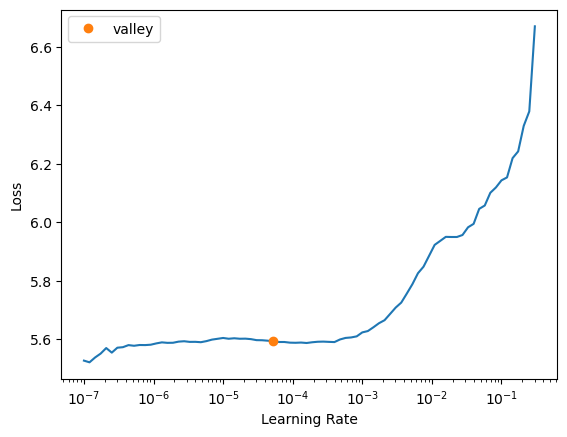

In [27]:
model = TSTPlus(dls.vars, dls.c, dls.len, dropout=0.3)
# learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=ShowGraphCallback2())
learnt.lr_find()


In [28]:
EPOCHS = 60
# num_layers: the number of sub-encoder-layers in the encoder. Usual values: 2-8. Default: 3.
# n_heads: parallel attention heads. Usual values: 8-16. Default: 16.
# dropout=0-0.3. Default: 0.1, fc_dropout=0-0.8. Default: 0

model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.3,n_layers=8)  
#learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learnt = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy],  cbs=[ShowGraph(), EarlyStoppingCallback(monitor='accuracy', patience=4)])
start = time.time()
learnt.fit_one_cycle(EPOCHS, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learnt.plot_metrics()


#EXPORT TRANSFORMER PROB
probast, _, predst = learnt.get_X_preds(X[splits[1]])

with open(f"{MODEL_DIR}/prob_trans.pkl", 'wb') as f3:
       pickle.dump(probast,f3)

pred_list['trans'] = predst
with open(f"{MODEL_DIR}/pred_tsai.pkl", 'wb') as f4:
       pickle.dump(pred_list,f4)

## SAVE MODEL
PATH = f"{MODEL_DIR}/model_trans{FRAMES_OUT}.pkl"
torch.save(learnt.model, PATH)

PATH = f"{MODEL_DIR}/model_trans{FRAMES_OUT}.sd"
torch.save(learnt.model.state_dict(), PATH)



epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
POST TENSOR
32 FRAMES TENSOR
50	1.604220	2.017758	0.733912	00:56
51	1.615538	2.019021	0.735111	00:56
52	1.604192	2.021329	0.734618	00:56

64 FRAMES  TENSOR
55	1.458071	2.106942	0.717824	00:54
56	1.441729	2.108713	0.716483	00:54
57	1.443853	2.103029	0.717189	00:54
..44	1.518437	2.116427	0.713167	00:53
45	1.503531	2.115704	0.712179	00:53
46	1.495585	2.114019	0.713026	00:52

PRE-TENSO
64 FRAMES
45	1.524049	2.136540	0.705899	00:51
46	1.514906	2.132602	0.706746	00:51
47	1.500723	2.126128	0.706393	00:51

32 FRAMES
54	1.481889	2.121107	0.716413	00:53
55	1.478437	2.122445	0.717894	00:53

32 FRAMES
44	1.663647	2.050606	0.723187	00:53
45	1.666268	2.055164	0.723751	00:53

# Try Conversion

In [ ]:
!pip install tensorflow --quiet --root-user-action=ignore
!pip install tensorflow_probability --quiet --root-user-action=ignore

!pip install onnx-tf --quiet --root-user-action=ignore
!pip install tflite-runtime  --quiet --root-user-action=ignore
import onnx_tf
import tflite_runtime
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

2023-04-29 21:27:18.283232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
## TSAI MODEL CONVERSION
# pmodel_path = f"{ARCHIVE_DIR}/models/modelccn16flat.sd"
# modelc = ASLModel(.1)
# modelc.load_state_dict(torch.load(py_model_path))
# modelc.eval()

#EXPORT MODEL
PATH = f"{ARCHIVE_DIR}/models/modelIncept.pkl"
learnia = load_learner(PATH)


sample_input = torch.rand((50, 60, 32))
onnx_mod_tsai_path = f"{MODEL_DIR}/model_tsai.onnx"

torch.onnx.export(
    learnia.model,                    # PyTorch Model
    sample_input,                    # Input tensor
    onnx_mod_tsai_path,        # Output file (eg. 'output_model.onnx')
    opset_version=12,         # Operator support version
    input_names=['input'],     # Input tensor name (arbitary)
    output_names=['output'], # Output tensor name (arbitary)
    dynamic_axes={'input' : {0: 'input'}
    }
)
onnx_mod_tsai_gen = onnx.load(onnx_mod_tsai_path)
tf_rep = prepare(onnx_mod_tsai_gen)

tf_mod_tsai_path = 'f"{MODEL_DIR}/tf_mod_tsai'
tf_rep.export_graph(tf_mod_tsai_path)



================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



2023-04-29 21:27:35.017849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '1278' with dtype float and shape [32,32,39]
	 [[{{node 1278}}]]


INFO:tensorflow:Assets written to: f"{MODEL_DIR}/tf_mod_tsai/assets


2023-04-29 21:27:36.988278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input' with dtype float and shape [?,60,32]
	 [[{{node serving_default_input}}]]
INFO:tensorflow:Assets written to: f"{MODEL_DIR}/tf_mod_tsai/assets
